<a href="https://colab.research.google.com/github/M-Pascal/Data_Preprocessing_PLD_6/blob/main/Data_preprocessing%5Bpipeline%5D_PLD_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1:** Data Augmentation on CSV Files

In [ ]:
# ===========================Import library===========================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor

from imblearn.over_sampling import SMOTE
from scipy.stats import skew

In [ ]:
# Mounting drive on the notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Y3_T1/Data_Preprocessing/dataset/customer_transactions.csv'
path_1 = '/content/drive/MyDrive/Y3_T1/Data_Preprocessing/dataset/customer_social_profiles.csv'
path_2 = '/content/drive/MyDrive/Y3_T1/Data_Preprocessing/dataset/id_mapping.csv'

df = pd.read_csv(path)

print(df.shape)
df.head()

(150, 6)


,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151,1001,408,2024-01-01,Sports,2.3
1,192,1002,332,2024-01-02,Electronics,4.2
2,114,1003,442,2024-01-03,Electronics,2.1
3,171,1004,256,2024-01-04,Clothing,2.8
4,160,1005,64,2024-01-05,Clothing,1.3


In [ ]:
# checking for missing values
df.isnull().sum()

,0
customer_id_legacy,0
transaction_id,0
purchase_amount,0
purchase_date,0
product_category,0
customer_rating,10


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id_legacy  150 non-null    int64  
 1   transaction_id      150 non-null    int64  
 2   purchase_amount     150 non-null    int64  
 3   purchase_date       150 non-null    object 
 4   product_category    150 non-null    object 
 5   customer_rating     140 non-null    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 7.2+ KB


# Handling Missing Values

While handling missing values, we used LGBM model where the missing values were prediceted instead of imputing them. However through the process, depending on the number of the missing values, mean, median and mode imputations were made to be the methods of handling missing data. This is more effective because it reduced the number of sub- datasets and checks the best possible method along the way.

In [ ]:
# dealing with missing value using LGBM model
cols_with_nans = [x for x in df.columns if df[x].isnull().sum() > 0]
cols_with_nans
# Checking how many missing value in it
df[cols_with_nans].isnull().sum()

,0
customer_rating,10


In [ ]:
# Identify numeric and categorical columns
num_cols = df.select_dtypes(include=['number']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Handle missing values
for col in num_cols:
    missing_count = df[col].isnull().sum()

    if missing_count == 0:
        continue

    print(f"Handling missing values in: {col} ({missing_count} missing)")

    if missing_count > int(len(df) / 2):
        df.drop(col, axis=1, inplace=True)  # Drop if >50% missing
        print(f"Dropped {col} due to excessive missing values.")
    else:
        if missing_count <= 5:  # Small number of missing values, use median
            df[col].fillna(df[col].median(), inplace=True)
            print(f"Filled {col} using Median Imputation.")
        else:
            # Use Predictive Modeling
            data = df.copy()
            nan_ixs = np.where(data[col].isna())[0]

            if len(nan_ixs) == 0:
                continue  # Skip if no missing values

            data["is_nan"] = 0
            data.loc[nan_ixs, "is_nan"] = 1

            # Convert categorical columns to numerical
            for cat_col in cat_cols:
                data[cat_col] = pd.factorize(data[cat_col])[0]

            train = data[data['is_nan'] == 0]
            test = data[data['is_nan'] == 1]

            x_train = train.drop(columns=[col, "is_nan"])
            y_train = train[col]
            x_test = test.drop(columns=[col, "is_nan"])

            if x_train.empty or x_test.empty:
                print(f"Skipping {col} due to insufficient data for modeling.")
                continue

            # Decision Tree Regression to predict missing values
            model = DecisionTreeRegressor(max_depth=5, random_state=42)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)

            df.loc[nan_ixs, col] = y_pred  # Fill missing values
            print(f"Filled {col} using Decision Tree Regression.")

# Handling missing categorical values
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)  # Fill with mode
        print(f"Filled {col} using Mode Imputation.")

Handling missing values in: customer_rating (10 missing)
Filled customer_rating using Decision Tree Regression.


In [ ]:
df.isnull().sum()

,0
customer_id_legacy,0
transaction_id,0
purchase_amount,0
purchase_date,0
product_category,0
customer_rating,0


In [ ]:
df.head(40)

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151,1001,408,2024-01-01,Sports,2.300
1,192,1002,332,2024-01-02,Electronics,4.200
2,114,1003,442,2024-01-03,Electronics,2.100
3,171,1004,256,2024-01-04,Clothing,2.800
4,160,1005,64,2024-01-05,Clothing,1.300
5,120,1006,395,2024-01-06,Groceries,1.100
6,182,1007,91,2024-01-07,Sports,4.900
7,186,1008,429,2024-01-08,Clothing,4.300
8,174,1009,228,2024-01-09,Electronics,3.800
9,174,1010,112,2024-01-10,Sports,2.600


In [ ]:

# Synthetic Data Generation
# Apply random noise to numerical transaction values
for col in df.select_dtypes(include=['number']).columns:
    noise = np.random.normal(0, 0.01 * df[col].std(), size=df.shape[0])  # Small Gaussian noise
    df[col] += noise
    print(f"Added noise to: {col}")

# Feature Value Transformation
# Identify skewed numerical columns and apply log transformation
num_cols = df.select_dtypes(include=['number']).columns
for col in num_cols:
    if abs(skew(df[col])) > 1:  # Check for skewness
        df[col] = np.log1p(df[col])  # Apply log transformation
        print(f"Applied log transformation to: {col}")

# Data Balancing using SMOTE
# Assuming the dataset has a categorical target variable
if "customer_segment" in df.columns:
    X = df.drop(columns=["customer_segment"])
    y = df["customer_segment"]

    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    df = pd.DataFrame(X_resampled, columns=X.columns)
    df["customer_segment"] = y_resampled

# Data Expansion (Generating Synthetic Transactions)
# Generate new transactions by sampling from existing patterns
num_synthetic_samples = int(0.2 * len(df))  # Generate 20% more synthetic data
synthetic_data = df.sample(n=num_synthetic_samples, replace=True).copy()

# Modify values slightly to create variability
for col in num_cols:
    synthetic_data[col] += np.random.normal(0, 0.02 * df[col].std(), size=num_synthetic_samples)

# Append synthetic data to original dataset
df = pd.concat([df, synthetic_data], ignore_index=True)
print(f"Generated {num_synthetic_samples} new synthetic transactions.")

# Export the Augmented Data
df.to_csv("customer_transactions_augmented.csv", index=False)
print("Data Augmentation Completed!")


Added noise to: customer_id_legacy
Added noise to: transaction_id
Added noise to: purchase_amount
Added noise to: customer_rating
Generated 30 new synthetic transactions.
Data Augmentation Completed!


In [ ]:
print(df.shape)
df.head()

(180, 6)


,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151.150795,1000.947669,408.430091,2024-01-01,Sports,2.314518
1,192.197680,1002.308100,332.951977,2024-01-02,Electronics,4.190436
2,113.343756,1003.709973,441.081798,2024-01-03,Electronics,2.124557
3,171.175801,1004.368199,255.148016,2024-01-04,Clothing,2.813893
4,159.865030,1004.726842,60.543445,2024-01-05,Clothing,1.296617


# **Part 2:** Merging Datasets with Transitive Properties

In [ ]:
# reading the saved dataset from part_1
df_transaction = pd.read_csv("customer_transactions_augmented.csv")
df_transaction.head()

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151.150795,1000.947669,408.430091,2024-01-01,Sports,2.314518
1,192.197680,1002.308100,332.951977,2024-01-02,Electronics,4.190436
2,113.343756,1003.709973,441.081798,2024-01-03,Electronics,2.124557
3,171.175801,1004.368199,255.148016,2024-01-04,Clothing,2.813893
4,159.865030,1004.726842,60.543445,2024-01-05,Clothing,1.296617


In [ ]:
# reading the customer social media profile dataset
df_social = pd.read_csv(path_1)
df_social.head()

,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment
0,A178,LinkedIn,74,4.9,Positive
1,A190,Twitter,82,4.8,Neutral
2,A150,Facebook,96,1.6,Positive
3,A162,Twitter,89,2.6,Positive
4,A197,Twitter,92,2.3,Neutral


In [ ]:
# read the id_mapping dataset
df_id = pd.read_csv(path_2)
df_id.head()

,customer_id_legacy,customer_id_new
0,195,A105
1,161,A118
2,192,A156
3,157,A168
4,166,A102


In [ ]:
# finding the link between the dataset

# Convert customer_id_legacy to int in both dataframes
df_transaction["customer_id_legacy"] = df_transaction["customer_id_legacy"].astype(int)
df_id["customer_id_legacy"] = df_id["customer_id_legacy"].astype(int)

# Check for missing values in customer_id_legacy
print("Missing values in df_transaction:", df_transaction["customer_id_legacy"].isnull().sum())
print("Missing values in df_id:", df_id["customer_id_legacy"].isnull().sum())

# Check for unique values in customer_id_legacy
print("Unique values in df_transaction:", df_transaction["customer_id_legacy"].nunique())
print("Unique values in df_id:", df_id["customer_id_legacy"].nunique())

# Check if all values in df_transaction exist in df_id
missing_ids = df_transaction[~df_transaction["customer_id_legacy"].isin(df_id["customer_id_legacy"])]
print("Rows in df_transaction with no matching customer_id_legacy in df_id:", len(missing_ids))

Missing values in df_transaction: 0
Missing values in df_id: 0
Unique values in df_transaction: 81
Unique values in df_id: 79
Rows in df_transaction with no matching customer_id_legacy in df_id: 44


In [ ]:
# Get the mismatched customer_id_legacy values
mismatched_ids = df_transaction[~df_transaction["customer_id_legacy"].isin(df_id["customer_id_legacy"])]["customer_id_legacy"].unique()
print("Mismatched customer_id_legacy values:", mismatched_ids)

Mismatched customer_id_legacy values: [171 185 102 100 148 160 153 117 107 143 142 133 172 184 123 108  99]


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: Read the provided datasets

# Load customer transactions dataset
transaction_df = pd.read_csv("customer_transactions_augmented.csv")

# Load customer social media profiles dataset
df_social = pd.read_csv(path_1)

# Load ID mapping dataset
df_id = pd.read_csv(path_2)

In [ ]:
# Step 2: Find the Link Between Datasets

# Convert customer_id_legacy in both datasets to int for consistency
transaction_df["customer_id_legacy"] = transaction_df["customer_id_legacy"].astype(int)
df_id["customer_id_legacy"] = df_id["customer_id_legacy"].astype(int)

# Merge transaction data with ID mapping to get customer_id_new
merged_transactions = transaction_df.merge(df_id, on="customer_id_legacy", how="left")

# Merge with social media data using customer_id_new
full_data = merged_transactions.merge(df_social, on="customer_id_new", how="left")

In [ ]:
# Step 3: Handle conflicts where one customer ID maps to multiple entries

# Identify conflicted legacy IDs with multiple mappings
conflicted_legacy_ids = merged_transactions[merged_transactions.duplicated(subset="customer_id_legacy", keep=False)]
print("Conflicted legacy IDs:", conflicted_legacy_ids["customer_id_legacy"].unique())

# Sort by purchase_date and keep the most recent mapping
merged_transactions = merged_transactions.sort_values(by="purchase_date", ascending=False)
merged_transactions = merged_transactions.drop_duplicates(subset="customer_id_legacy", keep="first")

Conflicted legacy IDs: [151 192 113 171 159 120 185 173 187 198 122 102 101 129 136 100 163 119
 132 174 157 148 189 141 190 158 178 161 160 146 150 153 162 106 138 103
 188 112 107 152 183 191 169 134 176 179 135 104 116 142 133 172 199 177
 184 180 125 139 127 144 164 108 109 131 126 111 197 145 121]


In [ ]:
# Step 4: Feature Engineering & Transformation

# Convert purchase_date to datetime format
full_data["purchase_date"] = pd.to_datetime(full_data["purchase_date"], errors='coerce')

# Extract time-based features
full_data["transaction_month"] = full_data["purchase_date"].dt.month
full_data["transaction_weekday"] = full_data["purchase_date"].dt.weekday  # 0 = Monday, 6 = Sunday

# Aggregate purchase amounts by month
monthly_agg = full_data.groupby(["customer_id_new", "transaction_month"])["purchase_amount"].agg(["sum", "mean"]).reset_index()
monthly_agg.rename(columns={"sum": "purchase_amount_monthly", "mean": "purchase_avg_monthly"}, inplace=True)

# Aggregate purchase amounts by weekday
weekday_agg = full_data.groupby(["customer_id_new", "transaction_weekday"])["purchase_amount"].agg(["sum", "mean"]).reset_index()
weekday_agg.rename(columns={"sum": "purchase_amount_weekday", "mean": "purchase_avg_weekday"}, inplace=True)

# Merge aggregated features back into the dataset
full_data = full_data.merge(monthly_agg, on=["customer_id_new", "transaction_month"], how="left", suffixes=("", "_monthly"))
full_data = full_data.merge(weekday_agg, on=["customer_id_new", "transaction_weekday"], how="left", suffixes=("", "_weekday"))

# Normalize engagement score and purchase interest score
scaler = MinMaxScaler()
full_data[["engagement_score", "purchase_interest_score"]] = scaler.fit_transform(full_data[["engagement_score", "purchase_interest_score"]])

# Compute new Customer Engagement Score (CES) as weighted sum
full_data["customer_engagement_score"] = (0.6 * full_data["engagement_score"]) + (0.4 * full_data["purchase_interest_score"])

In [ ]:
# checkin the dataframe
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448 entries, 0 to 447
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customer_id_legacy         448 non-null    int64         
 1   transaction_id             448 non-null    float64       
 2   purchase_amount            448 non-null    float64       
 3   purchase_date              448 non-null    datetime64[ns]
 4   product_category           448 non-null    object        
 5   customer_rating            448 non-null    float64       
 6   customer_id_new            404 non-null    object        
 7   social_media_platform      352 non-null    object        
 8   engagement_score           352 non-null    float64       
 9   purchase_interest_score    352 non-null    float64       
 10  review_sentiment           352 non-null    object        
 11  transaction_month          448 non-null    int32         
 12  transact

In [ ]:
# Step 5: TF-IDF Transformation on Social Media Comments
if "comments" in full_data.columns:
    tfidf_vectorizer = TfidfVectorizer(max_features=100)
    tfidf_matrix = tfidf_vectorizer.fit_transform(full_data["comments"].fillna(""))
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    full_data = pd.concat([full_data.reset_index(drop=True), tfidf_df], axis=1)

In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448 entries, 0 to 447
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customer_id_legacy         448 non-null    int64         
 1   transaction_id             448 non-null    float64       
 2   purchase_amount            448 non-null    float64       
 3   purchase_date              448 non-null    datetime64[ns]
 4   product_category           448 non-null    object        
 5   customer_rating            448 non-null    float64       
 6   customer_id_new            404 non-null    object        
 7   social_media_platform      352 non-null    object        
 8   engagement_score           352 non-null    float64       
 9   purchase_interest_score    352 non-null    float64       
 10  review_sentiment           352 non-null    object        
 11  transaction_month          448 non-null    int32         
 12  transact

In [ ]:
# Step 6: Handle missing mappings (drop rows where no mapping exists)
full_data.dropna(subset=["customer_id_new"], inplace=True)

# Step 7: Save the final preprocessed dataset
final_filename = "final_customer_data_PLD_6.csv"
full_data.to_csv(final_filename, index=False)
print(f"\nDatasets successfully linked and saved as '{final_filename}'")


Datasets successfully linked and saved as 'final_customer_data_PLD_6.csv'


In [ ]:
full_data.head()

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment,transaction_month,transaction_weekday,purchase_amount_monthly,purchase_avg_monthly,purchase_amount_weekday,purchase_avg_weekday,customer_engagement_score
0,151,1000.947669,408.430091,2024-01-01,Sports,2.314518,A176,Facebook,0.408163,0.575,Negative,1,0,1121.083482,186.847247,408.430091,408.430091,0.474898
1,192,1002.308100,332.951977,2024-01-02,Electronics,4.190436,A156,Instagram,0.040816,0.975,Positive,1,1,332.951977,332.951977,332.951977,332.951977,0.414490
2,192,1002.308100,332.951977,2024-01-02,Electronics,4.190436,A108,NaN,NaN,NaN,NaN,1,1,332.951977,332.951977,332.951977,332.951977,NaN
3,192,1002.308100,332.951977,2024-01-02,Electronics,4.190436,A110,NaN,NaN,NaN,NaN,1,1,332.951977,332.951977,1529.464011,305.892802,NaN
4,192,1002.308100,332.951977,2024-01-02,Electronics,4.190436,A140,LinkedIn,0.734694,0.525,Negative,1,1,614.443171,307.221586,332.951977,332.951977,0.650816


In [ ]:
df_final = pd.read_csv("final_customer_data_PLD_6.csv")
df_final.tail()

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment,transaction_month,transaction_weekday,purchase_amount_monthly,purchase_avg_monthly,purchase_amount_weekday,purchase_avg_weekday,customer_engagement_score
399,159,1003.483334,60.641029,2024-01-05,Clothing,1.282933,A176,Facebook,0.408163,0.575,Negative,1,4,1121.083482,186.847247,342.778469,114.25949,0.474898
400,159,1003.483334,60.641029,2024-01-05,Clothing,1.282933,A188,TikTok,0.000000,0.650,Positive,1,4,275.784909,68.946227,342.778469,114.25949,0.260000
401,152,1056.813353,307.873135,2024-02-27,Clothing,4.776832,A152,Facebook,0.918367,0.775,Positive,2,1,1229.890439,307.472610,1229.890439,307.47261,0.861020
402,152,1056.813353,307.873135,2024-02-27,Clothing,4.776832,A152,Instagram,0.632653,0.800,Positive,2,1,1229.890439,307.472610,1229.890439,307.47261,0.699592
403,152,1056.813353,307.873135,2024-02-27,Clothing,4.776832,A145,Twitter,0.857143,0.350,Neutral,2,1,709.091044,236.363681,614.945219,307.47261,0.654286


In [ ]:
print(df_final.shape)

(404, 18)


# **Part 3:** Data Consistency and Quality Checks

In [ ]:
# Load the preprocessed dataset
full_data = pd.read_csv("final_customer_data_PLD_6.csv")
full_data.head()

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment,transaction_month,transaction_weekday,purchase_amount_monthly,purchase_avg_monthly,purchase_amount_weekday,purchase_avg_weekday,customer_engagement_score
0,151,1000.947669,408.430091,2024-01-01,Sports,2.314518,A176,Facebook,0.408163,0.575,Negative,1,0,1121.083482,186.847247,408.430091,408.430091,0.474898
1,192,1002.308100,332.951977,2024-01-02,Electronics,4.190436,A156,Instagram,0.040816,0.975,Positive,1,1,332.951977,332.951977,332.951977,332.951977,0.414490
2,192,1002.308100,332.951977,2024-01-02,Electronics,4.190436,A108,NaN,NaN,NaN,NaN,1,1,332.951977,332.951977,332.951977,332.951977,NaN
3,192,1002.308100,332.951977,2024-01-02,Electronics,4.190436,A110,NaN,NaN,NaN,NaN,1,1,332.951977,332.951977,1529.464011,305.892802,NaN
4,192,1002.308100,332.951977,2024-01-02,Electronics,4.190436,A140,LinkedIn,0.734694,0.525,Negative,1,1,614.443171,307.221586,332.951977,332.951977,0.650816


In [ ]:
full_data.shape

(404, 18)

In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id_legacy         404 non-null    int64  
 1   transaction_id             404 non-null    float64
 2   purchase_amount            404 non-null    float64
 3   purchase_date              404 non-null    object 
 4   product_category           404 non-null    object 
 5   customer_rating            404 non-null    float64
 6   customer_id_new            404 non-null    object 
 7   social_media_platform      352 non-null    object 
 8   engagement_score           352 non-null    float64
 9   purchase_interest_score    352 non-null    float64
 10  review_sentiment           352 non-null    object 
 11  transaction_month          404 non-null    int64  
 12  transaction_weekday        404 non-null    int64  
 13  purchase_amount_monthly    404 non-null    float64

## Data Integrity Checks

In [ ]:
# Check for duplicate entries
duplicates = full_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
full_data.drop_duplicates(inplace=True)

Number of duplicate rows: 23


In [ ]:
full_data.shape

(381, 18)

In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381 entries, 0 to 403
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id_legacy         381 non-null    int64  
 1   transaction_id             381 non-null    float64
 2   purchase_amount            381 non-null    float64
 3   purchase_date              381 non-null    object 
 4   product_category           381 non-null    object 
 5   customer_rating            381 non-null    float64
 6   customer_id_new            381 non-null    object 
 7   social_media_platform      332 non-null    object 
 8   engagement_score           332 non-null    float64
 9   purchase_interest_score    332 non-null    float64
 10  review_sentiment           332 non-null    object 
 11  transaction_month          381 non-null    int64  
 12  transaction_weekday        381 non-null    int64  
 13  purchase_amount_monthly    381 non-null    float64
 14 

In [ ]:
# Ensure categorical values are correctly mapped
print("Categorical column value counts:")
categorical_columns = ["product_category", "social_media_platform", "review_sentiment"]
for col in categorical_columns:
    print(f"{col}:")
    print(full_data[col].value_counts())

Categorical column value counts:
product_category:
product_category
Groceries      86
Electronics    80
Sports         78
Books          72
Clothing       65
Name: count, dtype: int64
social_media_platform:
social_media_platform
TikTok       83
LinkedIn     77
Facebook     70
Instagram    55
Twitter      47
Name: count, dtype: int64
review_sentiment:
review_sentiment
Positive    122
Neutral     112
Negative     98
Name: count, dtype: int64


In [ ]:
# Validate that all customer transactions match a valid social profile
missing_social_profiles = full_data[full_data["customer_id_new"].isnull()]
print(f"Transactions without a valid social profile: {len(missing_social_profiles)}")

Transactions without a valid social profile: 0


In [ ]:
# Generate describe() report for numerical columns
print("Statistical Summary of Numerical Columns:")
full_data.describe()

Statistical Summary of Numerical Columns:


,customer_id_legacy,transaction_id,purchase_amount,customer_rating,engagement_score,purchase_interest_score,transaction_month,transaction_weekday,purchase_amount_monthly,purchase_avg_monthly,purchase_amount_weekday,purchase_avg_weekday,customer_engagement_score
count,381.000000,381.000000,381.000000,381.000000,332.000000,332.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,332.000000
mean,150.937008,1077.505671,286.892409,2.932788,0.548992,0.585843,3.039370,3.128609,1195.460217,287.312224,1195.033554,287.045891,0.563732
std,30.454733,43.679337,123.276090,1.197356,0.311591,0.264830,1.451324,1.861450,1027.107387,106.370873,1254.312131,107.815111,0.214481
min,101.000000,1000.947669,51.136721,1.010929,0.000000,0.000000,1.000000,0.000000,51.136721,51.136721,89.884597,77.300218,0.000000
25%,126.000000,1035.778305,185.047431,1.973861,0.285714,0.425000,2.000000,2.000000,472.198328,221.601500,392.623969,209.079855,0.392245
50%,152.000000,1079.949014,283.613544,2.900837,0.551020,0.650000,3.000000,3.000000,802.534989,291.500759,793.731683,286.941985,0.576122
75%,179.000000,1114.481824,392.623969,4.011624,0.816327,0.775000,4.000000,5.000000,1479.250619,366.621250,1475.155021,374.376545,0.741020
max,199.000000,1149.474872,495.789929,4.996928,1.000000,1.000000,5.000000,6.000000,4334.956887,495.789929,5992.435645,493.801809,0.920000


## Feature Selection for Machine Learning

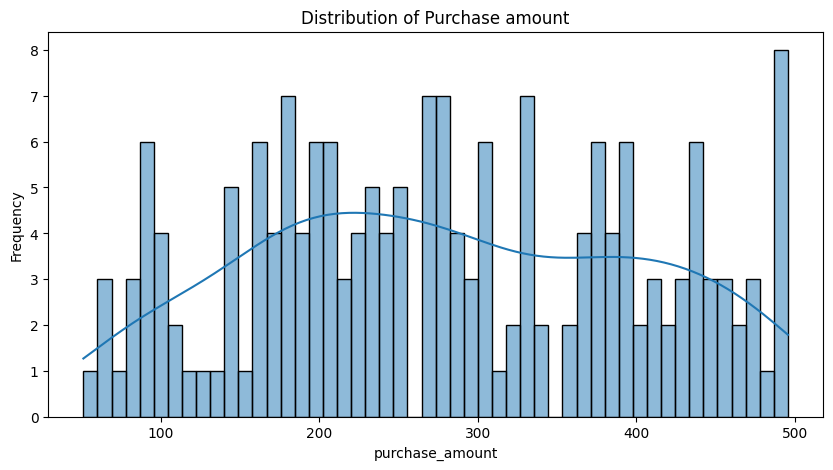

In [ ]:
# Visualize the distribution of Purchase amount before augmentation
plt.figure(figsize=(10, 5))
sns.histplot(df["purchase_amount"], bins=50, kde=True)
plt.title("Distribution of Purchase amount")
plt.xlabel("purchase_amount")
plt.ylabel("Frequency")
plt.show()

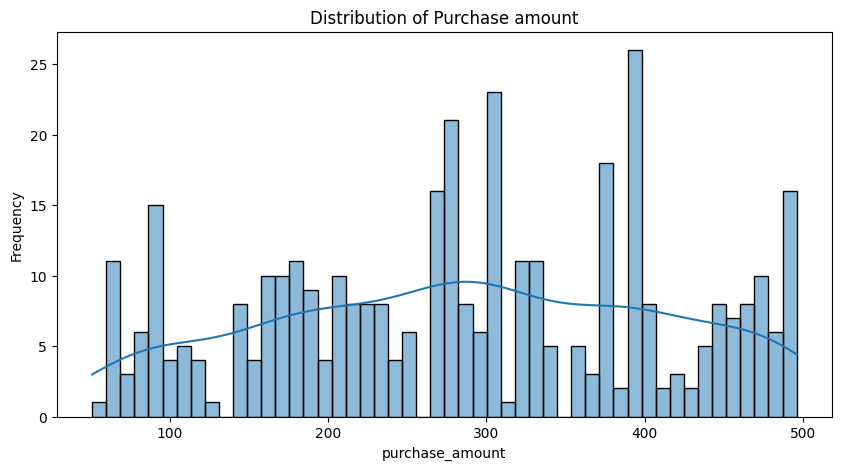

In [ ]:
# Visualize the distribution of Purchase amount after augmentation
plt.figure(figsize=(10, 5))
sns.histplot(full_data["purchase_amount"], bins=50, kde=True)
plt.title("Distribution of Purchase amount")
plt.xlabel("purchase_amount")
plt.ylabel("Frequency")
plt.show()

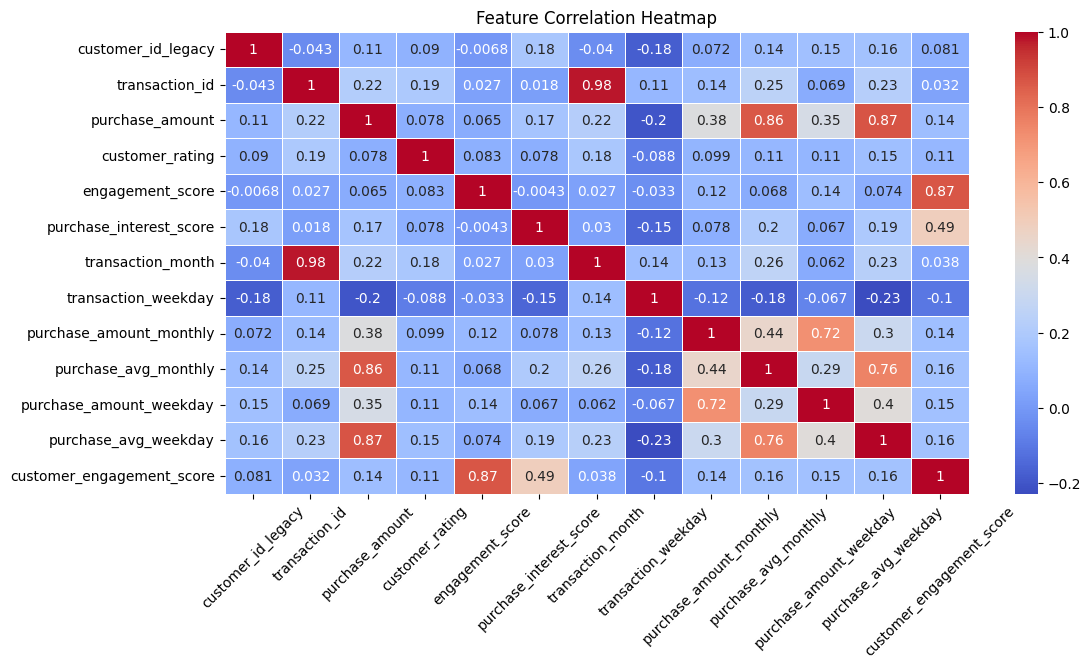

In [ ]:
# Identify highly correlated features using a correlation heatmap

# Selecting only numeric columns for correlation
numeric_df = full_data.select_dtypes(include=['number'])

plt.figure(figsize=(12, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.xticks(rotation=45)
plt.show()


## Selecting the top most important features using SelectKBest

In [ ]:
# Identify Non-Numeric Columns
non_numeric_cols = full_data.select_dtypes(exclude=['number']).columns
print("Non-Numeric Columns:", non_numeric_cols.tolist())

# Drop Irrelevant Columns (IDs, Dates)
columns_to_drop = ["customer_id_new", "customer_id_legacy", "purchase_date"]
full_data = full_data.drop(columns=columns_to_drop, errors='ignore')

# Convert Categorical Features into Numeric
label_encoders = {}
for col in full_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    full_data[col] = le.fit_transform(full_data[col].astype(str))  # Convert NaN to string for encoding
    label_encoders[col] = le

# Handle Missing Values
imputer = SimpleImputer(strategy="mean")  # Fill NaN with column mean (Change to "median" or "most_frequent" if needed)
full_data = pd.DataFrame(imputer.fit_transform(full_data), columns=full_data.columns)

# Define Features (X) and Target (y)
X = full_data.drop(columns=["purchase_interest_score"], errors='ignore')
y = full_data["purchase_interest_score"]

# Feature Selection using SelectKBest
selector = SelectKBest(score_func=f_classif, k=min(10, X.shape[1]))
X_new = selector.fit_transform(X, y)

# Display Selected Features
selected_features = X.columns[selector.get_support()]
print("Top selected features:", selected_features.tolist())


Non-Numeric Columns: ['purchase_date', 'product_category', 'customer_id_new', 'social_media_platform', 'review_sentiment']
Top selected features: ['purchase_amount', 'social_media_platform', 'engagement_score', 'review_sentiment', 'transaction_weekday', 'purchase_amount_monthly', 'purchase_avg_monthly', 'purchase_amount_weekday', 'purchase_avg_weekday', 'customer_engagement_score']


In [ ]:
# Save the final dataset for machine learning
final_filename = "final_dataset_ready_PLD_6.csv"
full_data.to_csv(final_filename, index=False)
print(f"Final dataset saved as {final_filename}")

Final dataset saved as final_dataset_ready_PLD_6.csv


In [ ]:
# Reading the saved cleaned data (encodered data)
df_clean = pd.read_csv("final_dataset_ready_PLD_6.csv")
df_clean.tail()

,transaction_id,purchase_amount,product_category,customer_rating,social_media_platform,engagement_score,purchase_interest_score,review_sentiment,transaction_month,transaction_weekday,purchase_amount_monthly,purchase_avg_monthly,purchase_amount_weekday,purchase_avg_weekday,customer_engagement_score
376,1003.483334,60.641029,1.0,1.282933,0.0,0.408163,0.575,0.0,1.0,4.0,1121.083482,186.847247,342.778469,114.25949,0.474898
377,1003.483334,60.641029,1.0,1.282933,3.0,0.000000,0.650,2.0,1.0,4.0,275.784909,68.946227,342.778469,114.25949,0.260000
378,1056.813353,307.873135,1.0,4.776832,0.0,0.918367,0.775,2.0,2.0,1.0,1229.890439,307.472610,1229.890439,307.47261,0.861020
379,1056.813353,307.873135,1.0,4.776832,1.0,0.632653,0.800,2.0,2.0,1.0,1229.890439,307.472610,1229.890439,307.47261,0.699592
380,1056.813353,307.873135,1.0,4.776832,4.0,0.857143,0.350,1.0,2.0,1.0,709.091044,236.363681,614.945219,307.47261,0.654286


In [ ]:
df_clean.shape

(381, 15)

In [ ]:
# checking missing value
df_clean.isnull().sum()

,0
transaction_id,0
purchase_amount,0
product_category,0
customer_rating,0
social_media_platform,0
engagement_score,0
purchase_interest_score,0
review_sentiment,0
transaction_month,0
transaction_weekday,0


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_id             381 non-null    float64
 1   purchase_amount            381 non-null    float64
 2   product_category           381 non-null    float64
 3   customer_rating            381 non-null    float64
 4   social_media_platform      381 non-null    float64
 5   engagement_score           381 non-null    float64
 6   purchase_interest_score    381 non-null    float64
 7   review_sentiment           381 non-null    float64
 8   transaction_month          381 non-null    float64
 9   transaction_weekday        381 non-null    float64
 10  purchase_amount_monthly    381 non-null    float64
 11  purchase_avg_monthly       381 non-null    float64
 12  purchase_amount_weekday    381 non-null    float64
 13  purchase_avg_weekday       381 non-null    float64

# **Part_4:** Model training

In [ ]:
# Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Define Features (X) and Target (y)
X = df_clean.drop(columns=["purchase_amount"])
y = df_clean["purchase_amount"]

# Split Data into Training & Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Train Models & Evaluate
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Predictions
y_pred = model.predict(X_test)

In [ ]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

Mean Absolute Error (MAE): 38.27
Mean Squared Error (MSE): 2715.68
Root Mean Squared Error (RMSE): 52.11
R2 Score: 0.8184


In [ ]:
# =========================================The End=========================================